In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import os
import random
import csv
import time
import tqdm
from scipy.spatial.distance import cdist

import warnings
np.seterr(all='raise')
warnings.filterwarnings('error')

In [2]:
class DataAugmentation():
    
    def __init__(self, label_def, IMAGE_DIMENSION= [480, 640], NUM_OF_SCALES= 2, 
                   IMAGE_PATH= './objects/image', LABEL_PATH= './objects/label', IMG_TYPE= '.jpg',
                    MIN_OBJ_AREA_PERCENT= 0.3, MAX_OBJ_AREA_PERCENT= 70):

        self.label_def = label_def
        self.image_dimension = IMAGE_DIMENSION
        self.image_path = IMAGE_PATH
        self.label_path = LABEL_PATH
        self.img_type = IMG_TYPE
        self.min_obj_area_percent = MIN_OBJ_AREA_PERCENT
        self.max_obj_area_percent = MAX_OBJ_AREA_PERCENT
        self.regenerate_augment_vector_count = 0
        
        files_count, object_paths = self.fetch_image_gt_paths()
        
        if NUM_OF_SCALES is 'RANDOMIZE':
            self.num_of_scales = np.random.randint(1, 5, size= files_count)
            self.num_objects = np.sum(self.num_of_scales)
        else:
            self.num_of_scales = NUM_OF_SCALES
            self.num_objects = self.num_of_scales * files_count
            
        self.background_images = self.get_background_images()
        self.objects = self.get_synthetic_objects_list(object_paths)
        self.augment_vector = list()
    
    def fetch_image_gt_paths(self):
        """
        This function counts the number of annotated images and
        fetches the path of the images and corresponding labels..
        
        Returns the number of annotated images and a dictionary mapping
        the object name to the corresponding image and label paths...
        """
        object_paths = dict()
        files_count = 0
        for obj_dir in os.listdir(self.label_path):
            obj_files = list()
            for files in sorted(os.listdir(os.path.join(self.label_path, obj_dir))):
                files_count += 1
                obj_files.append([os.path.join(self.image_path, obj_dir, files.split('.')[0]+self.img_type), 
                         os.path.join(self.label_path, obj_dir, files)])
            object_paths[obj_dir] = obj_files.copy()
            
        return files_count, object_paths
    
    def get_background_images(self):
        
        """
        This function reads the background images and creates a list...
        """

        background_files = os.listdir('./backgrounds')
        background_files = [os.path.join('./backgrounds', file) for file in background_files]
        background_images = list()
        for file in background_files:
            background_images.append(cv2.imread(file))
            
        return background_images
    
    def create_augment_vector(self, augment_vector_length= None, REMOVE_CLUTTER= True,
                             NUM_OF_IMAGES= 50, MAX_OBJECTS_PER_IMAGE= 6, GENERATION_REATTEMPTS= 100,
                             CLEAR_AUGMENT_VECTOR= True, MIN_DIST_BTW_LOCATIONS= 70, MAX_OCCUPIED_AREA= 0.8):
        
        """
        This function creates a randomized augment vector, based on 
        which the images are augmented..
        
        # parameters which are randomized:
            1. 'background_image': selects a random background image.
                    It is also ensured that all backgrounds are selected once
                    before randomizing again.
                    
            2. 'num_objects_to_place': number of objects to be placed in
                    the image.
            
            3. 'what_objects': a list of random indices are created. Objects in
                    the corresponding indices will be chosen for augmentation.
                    
            4. 'locations': randomized (x,y) in the pixel space for each object..
        """
        
        if CLEAR_AUGMENT_VECTOR:
            self.augment_vector.clear()
        
        self.generation_reattempts = GENERATION_REATTEMPTS
        self.min_dist_btw_locations = MIN_DIST_BTW_LOCATIONS
        self.max_occupied_area = MAX_OCCUPIED_AREA
        num_of_images = NUM_OF_IMAGES if augment_vector_length is None else augment_vector_length
        objects_index = np.arange(0, self.num_objects)

        for i in range(num_of_images):
            num_objects_to_place = np.random.randint(1, high= MAX_OBJECTS_PER_IMAGE)
            what_objects = [objects_index[i] for i in range(num_objects_to_place)]
    
            if i % len(self.background_images) == 0:
                np.random.shuffle(self.background_images)
        
            #if i % num_objects == 0:
            np.random.shuffle(objects_index)
        
            self.augment_vector.append({'background_image': self.background_images[
                                                            i % len(self.background_images)], 
                       'num_objects_to_place': num_objects_to_place, 
                       'what_objects': what_objects,
                      'locations': self.get_random_locations(num_objects_to_place)})
        
        if REMOVE_CLUTTER:
            self.remove_clutter()
            
    def remove_clutter(self):
        """
        This function removes vectors with too many objects and too much object occlusion
        """
        
        removed_vectors = 0
        for index, vector in enumerate(self.augment_vector):
            vector_area = 0
            for i in range(vector['num_objects_to_place']):
                vector_area += self.objects[vector['what_objects'][i]]['obj_area']
            dist_btw_locations = cdist(vector['locations'], vector['locations'])
            np.fill_diagonal(dist_btw_locations, np.inf)
            if (vector_area > self.image_dimension[0] * self.image_dimension[1] * self.max_occupied_area or
                        np.any(dist_btw_locations<self.min_dist_btw_locations)):
                del self.augment_vector[index]
                removed_vectors += 1
            
        if self.regenerate_augment_vector_count < self.generation_reattempts and removed_vectors is not 0:
            self.create_augment_vector(augment_vector_length= removed_vectors, CLEAR_AUGMENT_VECTOR= False)
            self.regenerate_augment_vector_count += 1
    
    def get_random_locations(self, num_objects_to_place):
        
        """
        Generate a list of random (x,y) points..
        """
        location = [[random.randrange(0, 440, 120), random.randrange(0, 600, 120)]
               for _ in range(num_objects_to_place)]
        
        return np.array(location)
    
    def plot_img_and_label(self, image, label, img_num, obj_det_label= None):
        
        """
        Visualize the augmented image, it's corresponding semantic segmentation 
        label and object detection label.
        
        preview_data: can be used to preview data within the notebook...
        save_data_preview: can be used to save the plots...
        """
        if self.preview_data or self.save_data_preview:
            label = label.copy()
            if obj_det_label is not None:
                for l in obj_det_label:
                    for i in range(l[1], l[3]+1):
                        if i < self.image_dimension[0]:
                            label[i, l[2]:l[2]+3] = len(label_def) + 1
                            label[i, l[4]-3:l[4]] = len(label_def) + 1

                    for i in range(l[2], l[4]+1):
                        if i < self.image_dimension[1]:
                            label[l[1]:l[1]+3, i] = len(label_def) + 1
                            label[l[3]-3:l[3], i] = len(label_def) + 1

            figure = plt.figure()
            figure.set_figheight(15)
            figure.set_figwidth(15)
            figure.add_subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            figure.add_subplot(1, 2, 2)
            plt.imshow(label)
            if self.save_data_preview:
                plt.savefig('./data_augmentation_results/image_and_gt/'+str(img_num)+'.png')
                result = cv2.imread('./data_augmentation_results/image_and_gt/'+str(img_num)+'.png', 1)
                result = result[320:750,50:1030,:]
                cv2.imwrite('./data_augmentation_results/image_and_gt/'+str(img_num)+'.png', result)
            plt.show() if self.preview_data else plt.close(figure)
        
    def find_obj_loc_and_vals(self, image, label, label_value, obj_name):
        
        """
        This function returns a dictionary which links:
            1. 'obj_loc' to (x,y) locations of the object obtained using 
                the label definition...
            2. 'obj_vals' to the intensity values of the object in the 
                corresponding 'obj_loc'...
            3. 'label_vals' to an array whose all elements is the value of
                the object label...
            4. 'obj_name' to the name of the object..
            5. 'rect_points' to the coordinates of the points to obtain bounding rectangle.
            6. 'obj_area' to the area occupied by the object in pixel space.
        
        """
        obj_loc = np.argwhere(label==label_value)
        obj_vals = [image[tuple(loc)] for loc in obj_loc]
        obj_vals = np.array(obj_vals)
        label_vals = np.ones(len(obj_loc)) * label_value
        rect_points = [min(obj_loc[:,0]), min(obj_loc[:,1]), max(obj_loc[:,0]), max(obj_loc[:,1])]
        obj_area = (rect_points[2] - rect_points[0]) * (rect_points[3] - rect_points[1])
        
        return {'obj_loc': obj_loc, 'obj_vals': obj_vals, 'label_vals': label_vals, 
                'obj_name': obj_name, 'rect_points': rect_points, 'obj_area': obj_area}
    
    def get_different_scales(self, image, image_label, label_value, obj_name, obj_num):
        
        """
        This functions creates different scales of the object based on the
        number of scales parameter and removes objects which are too small..
        """
        
        if type(self.num_of_scales) is np.ndarray:
            num_scales = self.num_of_scales[obj_num]
            scale_difference = 1/self.num_of_scales[obj_num]
        else:
            num_scales = self.num_of_scales
            scale_difference = 1/self.num_of_scales
        scales = [i * scale_difference for i in range(1, num_scales+1)]
            
        scaled_objects = list()

        for i in range(0, num_scales):
            scaled_objects.append(self.find_obj_loc_and_vals(
                    cv2.resize(image, (0,0), fx=scales[i], fy=scales[i]), 
                    cv2.resize(image_label, (0,0), fx=scales[i], fy=scales[i]), 
                    label_value, obj_name))
        
        image_area = self.image_dimension[0] * self.image_dimension[1]
        remove_objects = list()
        for obj in scaled_objects:
            if not (self.min_obj_area_percent/100 * image_area < obj['obj_area'] < 
                self.max_obj_area_percent/100 * image_area):
                remove_objects.append(obj)
                
        for obj in remove_objects:
            scaled_objects.remove(obj)
            self.num_objects -= 1

        return scaled_objects
    
    def get_synthetic_objects_list(self, object_paths):
        
        """
        This function reads all the images and its coresponding labels...
        Creates a dictionary which maps the object name to the list of objects and labels...
        """
        objects = list()
        obj_num = -1
        for key in tqdm.tqdm(self.label_def, desc= 'Loading images and gts class by class'):
            if key is not 'background':
                data_list = object_paths[key]
                for data in data_list:
                    obj_num += 1
                    img = cv2.imread(data[0])
                    label = cv2.imread(data[1], 0)
                    objects += self.get_different_scales(img, label, label_def[key], key, obj_num)
                    
        return objects
    
    def get_augmented_image(self, original_image, original_label, obj_vals, location):
        
        """
        This function gets the image and label which needs to be augmented, the object details
        and the random location in which the object needs to be placed as arguments..
        
        The existing object location is shifted based on the location argument and the
        intensity values of the object are now placed in the shifted location...
        
        The resultant augmented image and label is returned...
        """
        augmented_image = original_image.copy()
        augmented_label = original_label.copy()
        obj_vals_to_augment = copy.deepcopy(obj_vals)
        
        row_shift = min(obj_vals_to_augment['obj_loc'][:,0]) - location[0]
        col_shift = min(obj_vals_to_augment['obj_loc'][:,1]) - location[1]
        obj_vals_to_augment['obj_loc'][:,0] -= row_shift
        obj_vals_to_augment['obj_loc'][:,1] -= col_shift

        for index,loc in enumerate(obj_vals_to_augment['obj_loc']):
            if 0 < loc[0] < self.image_dimension[0] and 0 < loc[1] < self.image_dimension[1]:
                augmented_image[tuple(loc)] = obj_vals_to_augment['obj_vals'][index]
                augmented_label[tuple(loc)] = obj_vals_to_augment['label_vals'][index]

        if self.get_obj_det_label:
            rect_points = [r - s for r, s in zip(obj_vals_to_augment['rect_points'], 
                                                 [row_shift, col_shift, row_shift, col_shift])]
            
            obj_det_label = [obj_vals_to_augment['obj_name']] + rect_points
            return augmented_image, augmented_label, obj_det_label

        return augmented_image, augmented_label
    
    def perform_augmentation(self, preview_data= False, save_data_preview= False, get_obj_det_label= True):
        
        """
        This function goes through the augment vector and performs augmentation 
        for each augment vector.. The result is saved along with semantic segmentation
        labels and object detection labels (if get_obj_det_label is true)...
        
        In each augment vector, objects in 'what_objects' is taken and pasted on top
        of the 'background_image' in the augment vector... 
        
        The augmented image and label are then saved. Object detection labels are saved
        in a csv (one for every augment vector) if get_obj_det_label is true...
        """
        
        self.preview_data = preview_data
        self.save_data_preview = save_data_preview
        self.get_obj_det_label = get_obj_det_label
        
        obj_det_label = list()
        background_label = np.ones(tuple(self.image_dimension)) * self.label_def['background']
        for index, vector in enumerate(tqdm.tqdm(self.augment_vector, desc= 'Generating synthetic images')):
            augmented_image, augmented_label = vector['background_image'], background_label.copy()
            obj_det_label.clear()
            for i in range(vector['num_objects_to_place']):

                if self.get_obj_det_label:
                    augmented_image, augmented_label, rect_label = self.get_augmented_image(augmented_image, 
                                                        augmented_label, 
                                                           self.objects[vector['what_objects'][i]], 
                                                               vector['locations'][i])
                    obj_det_label.append(rect_label)
                else:
                    augmented_image, augmented_label = self.get_augmented_image(augmented_image, 
                                                        augmented_label, 
                                                           self.objects[vector['what_objects'][i]], 
                                                               vector['locations'][i])

            if self.get_obj_det_label:
                self.plot_img_and_label(augmented_image, augmented_label, index, obj_det_label)
                cv2.imwrite('./data_augmentation_results/image/'+str(index)+'.png', augmented_image)
                cv2.imwrite('./data_augmentation_results/ground_truth/'+str(index)+'.png', augmented_label)
                with open('./data_augmentation_results/obj_det/'+str(index)+'.csv','w') as f:
                    wr = csv.writer(f,delimiter=',')
                    [wr.writerow(l) for l in obj_det_label]

            else:
                plot_img_and_label(augmented_image, augmented_label, index)
                cv2.imwrite('./data_augmentation_results/image/'+str(index)+'.png', augmented_image)
                cv2.imwrite('./data_augmentation_results/ground_truth/'+str(index)+'.png', augmented_label)

In [3]:
label_def = {'f20_20_B': 1, 's40_40_B': 2, 'f20_20_G': 3, 's40_40_G': 4,  'm20_100': 5, 
             'm20': 6, 'm30': 7, 'r20': 8, 'bearing_box_ax01': 9, 'bearing': 10, 'axis': 11, 
             'distance_tube': 12, 'motor': 13, 'container_box_blue': 14, 'container_box_red': 15, 
             'bearing_box_ax16': 16, 'em_01': 17, 'em_02': 18, 'background': 19}
augmenter = DataAugmentation(label_def, NUM_OF_SCALES= 'RANDOMIZE')

Loading images and gts class by class: 100%|██████████| 19/19 [00:48<00:00,  2.54s/it]


Generating synthetic images:   0%|          | 0/5 [00:00<?, ?it/s]

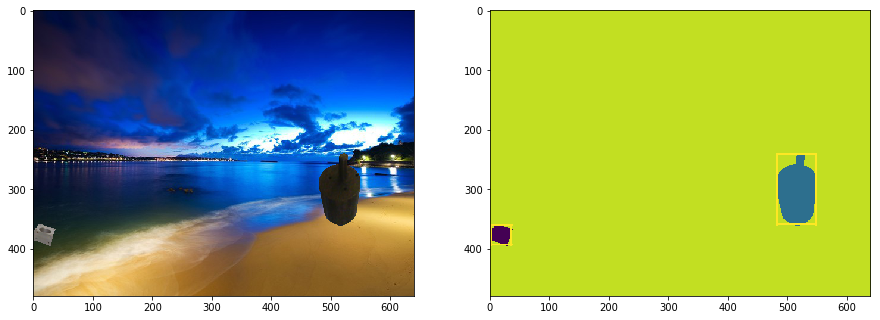

Generating synthetic images:  20%|██        | 1/5 [00:00<00:03,  1.30it/s]

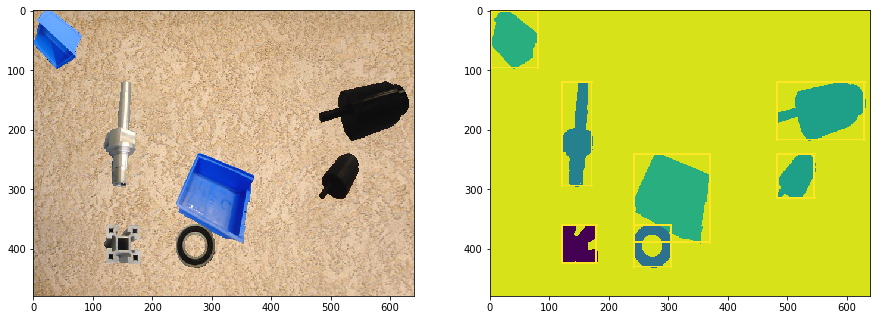

Generating synthetic images:  40%|████      | 2/5 [00:01<00:02,  1.11it/s]

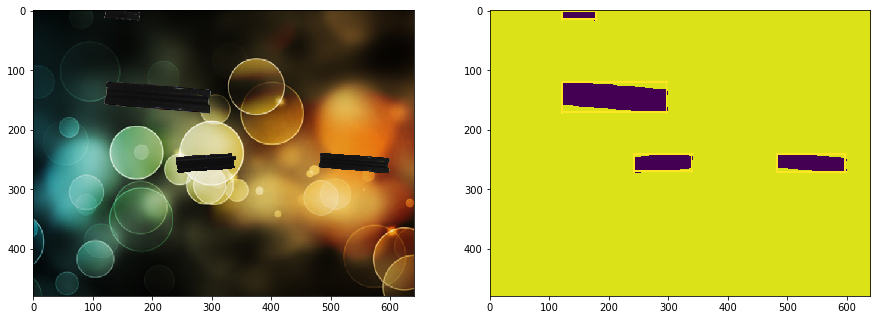

Generating synthetic images:  60%|██████    | 3/5 [00:02<00:01,  1.06it/s]

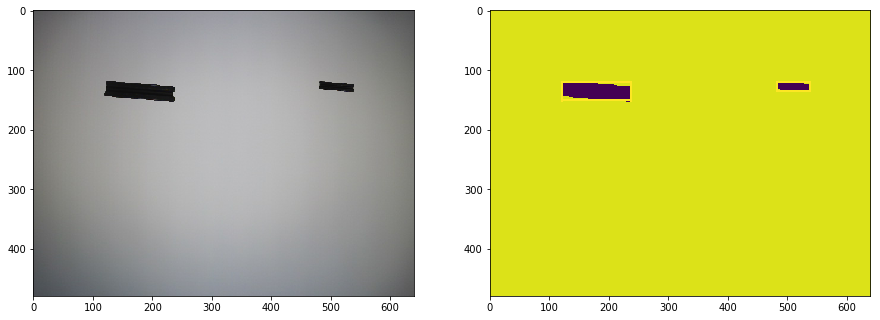

Generating synthetic images:  80%|████████  | 4/5 [00:03<00:00,  1.06it/s]

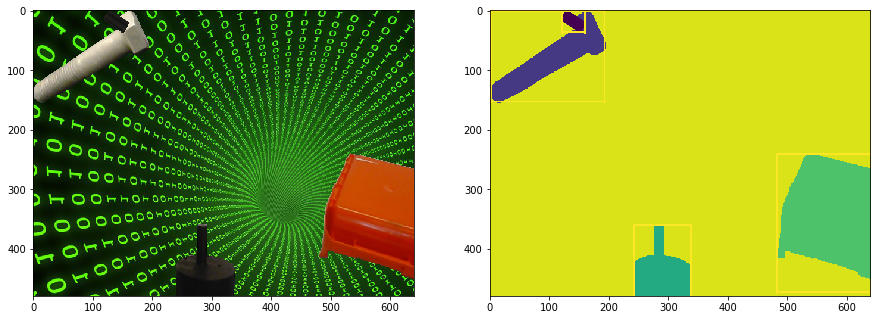

Generating synthetic images: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


In [8]:
start = time.time()
augmenter.create_augment_vector(NUM_OF_IMAGES= 5, MAX_OBJECTS_PER_IMAGE= 25)
augmenter.perform_augmentation(save_data_preview= True, preview_data= True)
time_taken = time.time() - start

In [ ]:
print ('Total time taken to generate synthetic images is {} seconds'.format(time_taken))

In [ ]:
"""
5. Fix overlapping obj detection labels..
6. When large object leaves pixel space, object detection label is too large.. see ./problem_6.png...
"""

import os
PATH = './backgrounds/'
files = os.listdir(PATH)
for index, file in enumerate(files):
    if index+1<=9:
        os.rename(PATH+file, PATH+'background_000'+str(index+1)+'.'+file.split('.')[-1])
    elif index+1<=99:
        os.rename(PATH+file, PATH+'background_00'+str(index+1)+'.'+file.split('.')[-1])
    else:
        os.rename(PATH+file, PATH+'background_0'+str(index+1)+'.'+file.split('.')[-1])